In [40]:
import pandas as pd

import numpy as np
from numpy.random import seed
from numpy.random import randn

from scipy.stats import mannwhitneyu
from scipy.stats import norm

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

plt.style.use('ggplot')

%config IPCompleter.greedy = True

In [6]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/389496/hw_bootstrap.csv', sep=';')
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"9,77311267424938",Treatment
1,2,"9,31124557661141",Treatment
2,3,"11,1728280618157",Treatment
3,4,"11,6245100581039",Treatment
4,5,"10,4623312287876",Treatment


In [ ]:
# Приводим данные к правильному виду для Питончика(float)

In [32]:
Treatment = pd.to_numeric(df[df.experimentVariant == 'Treatment'].value.str.replace(',', '.'))
Control = pd.to_numeric(df[df.experimentVariant == 'Control'].value.str.replace(',', '.'))

In [12]:
def get_bootstrap(
    data_column_1, # Числовые значения первой выборки
    data_column_2, # Числовые значения второй выборки
    boot_it = 1000, # Количество бутстрэп-подвыборок
    statistic = np.mean, # Интересующая нас статистика
    bootstrap_conf_level = 0.95 # Уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # Извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # Параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # Чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [13]:
# Будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

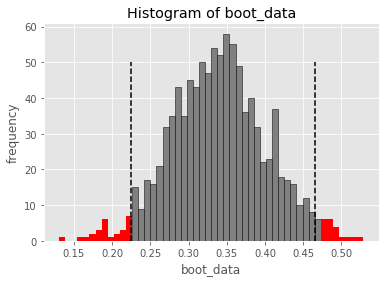

In [36]:
booted_data = get_bootstrap(Treatment, Control) # В результате хранится разница двух распределений, ДИ и pvalue

In [38]:
booted_data["quants"] # ДИ

,0
0.025,0.225179
0.975,0.465068


In [ ]:
# p_value Бутстрепа

In [37]:
booted_data["p_value"] # Альфа

3.8877275689703284e-08

In [ ]:
# p_value U-критерия Манна-Уитни

In [42]:
stat, p = mannwhitneyu(Treatment, Control)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=9508.000, p=0.003


В бутстрепе для проверки уровня значимости мы установили значение 0.95. Это значит что если А будет отличаться от В более чем на 0.95, то это будет говороить о том что у нас есть значимые различия. А в критерии Манна-Уитни мы отклоняем нулевую гепотезу, тк если если она верна, то вероятность получить такие или еще более значимые различия меньше 0.05
Вывод: оба теста говорят о статистически значимых различиях в тесте и контроле.
P.S Я в процессе изучения и не совсем уверен в выводе, как минимум из-за того что в группах сильно разное колл-во
наблюдений, возможно это оказывает влияние на 2й тест(Манна-Уитни). Буду разбираться дальше)